In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

#### Read images and labels

In [2]:
images_original = np.load('/ai_project/to_read/dataset_original.npy')
images_reduced_augmented = np.load('/ai_project/to_read/dataset_reduced_and_augemented.npy')

labels_original = np.load('/ai_project/to_read/labels_original.npy', allow_pickle=True)
labels_reduced_augmented = np.load('/ai_project/to_read/labels_reduced_augmented.npy', allow_pickle=True)

#### Visualize some images from both datasets

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/pyplot.py'>

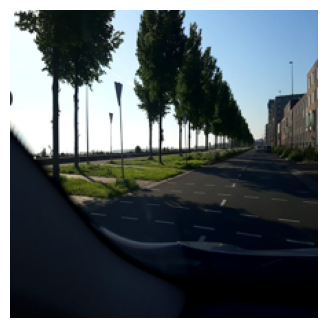

In [3]:
image_index = 1900
image_data = images_reduced_augmented[image_index]

plt.figure(figsize=(6, 4))
plt.imshow(image_data, cmap="gray") 
plt.axis("off") 
plt


In [4]:
labels_reduced_augmented[1900]

array(['3080.jpg', 'IJburg, Zeeburgereiland'], dtype=object)

In [5]:
labels_original = labels_original[:, 1]
labels_reduced_augmented = labels_reduced_augmented[:, 1]

#### Check if there are any missing images/labels. If so, delete them

In [6]:
nan_indices_images_original = np.where(pd.isnull(images_original))[0] 
print("Indices with NaNs (images [original]):", nan_indices_images_original)
nan_indices_images_reduced_augmented = np.where(pd.isnull(images_reduced_augmented))[0] 
print("Indices with NaNs (images [reduced_augmented]):", nan_indices_images_reduced_augmented)

nan_indices_labels_original = np.where(pd.isnull(labels_original))[0] 
print("Indices with NaNs (labels [original]):", nan_indices_labels_original)
nan_indices_labels_reduced_augmented = np.where(pd.isnull(labels_reduced_augmented))[0] 
print("Indices with NaNs (labels [reduced_augmented]):", nan_indices_labels_reduced_augmented)

Indices with NaNs (images [original]): []
Indices with NaNs (images [reduced_augmented]): []
Indices with NaNs (labels [original]): [4964 7326]
Indices with NaNs (labels [reduced_augmented]): [3764 5521]


In [7]:
images_original = np.delete(images_original, nan_indices_labels_original, axis=0)
labels_original = np.delete(labels_original, nan_indices_labels_original)

In [8]:
images_reduced_augmented = np.delete(images_reduced_augmented, nan_indices_labels_reduced_augmented, axis=0)
labels_reduced_augmented = np.delete(labels_reduced_augmented, nan_indices_labels_reduced_augmented)

#### Due to technical limitations resulting in crashing kernel, original and reduced/augmented datasets were reduced, to 0.50 and 0.60 of original sizes respectively

In [9]:
images_original, _, labels_original, _ = train_test_split(
    images_original, labels_original, test_size=0.5, random_state=42, stratify=labels_original)

images_reduced_augmented, _, labels_reduced_augmented, _ = train_test_split(
    images_reduced_augmented, labels_reduced_augmented, test_size=0.4, random_state=42, stratify=labels_reduced_augmented)

In [10]:
print(len(images_original))
print(len(images_reduced_augmented))

10576
9571


#### As a result, sizes of datasets:
#### - original: 10576
#### - reduced and augmented: 9571

In [11]:
images_original_train, images_original_test, labels_original_train, labels_original_test = train_test_split(
    images_original, labels_original, test_size=0.2, random_state=42, stratify=labels_original)

images_reduced_augmented_train, images_reduced_augmented_test, labels_reduced_augmented_train, labels_reduced_augmented_test = train_test_split(
    images_reduced_augmented, labels_reduced_augmented, test_size=0.2, random_state=42, stratify=labels_reduced_augmented)


#### Train/test split maintains the original proportion of neighborhoods in the datasets

In [12]:
unique_categories_reduced_augmented, counts_reduced_augmented = np.unique(labels_reduced_augmented_train, return_counts=True)

summary_reduced_augmented = {k: int(v) for k, v in zip(unique_categories_reduced_augmented, counts_reduced_augmented)}
summary_reduced_augmented

{'Bijlmer-Oost': 774,
 'Bos en Lommer': 960,
 'Gaasperdam': 742,
 'IJburg, Zeeburgereiland': 808,
 'Noord-Oost': 960,
 'Noord-West': 960,
 'Oud-Zuid': 737,
 'Slotervaart': 913,
 'Watergraafsmeer': 802}

In [13]:
unique_categories_original, counts_original = np.unique(labels_original_train, return_counts=True)

summary_original = {k: int(v) for k, v in zip(unique_categories_original, counts_original)}
summary_original

{'Bijlmer-Oost': 346,
 'Bos en Lommer': 3666,
 'Gaasperdam': 319,
 'IJburg, Zeeburgereiland': 673,
 'Noord-Oost': 910,
 'Noord-West': 1103,
 'Oud-Zuid': 314,
 'Slotervaart': 760,
 'Watergraafsmeer': 369}

In [14]:
max_occurrences_reduced_augmented = max(summary_reduced_augmented.values())
max_occurrences_original = max(summary_original.values())

In [15]:
bg_probability_reduced_augmented = max_occurrences_reduced_augmented / len(labels_reduced_augmented_train)
bg_probability_original = max_occurrences_original / len(labels_original_train)

print('"successful blind guess" probability in reduced and augmented dataset: ' + str(round(bg_probability_reduced_augmented, 3)))
print('"successful blind guess" probability in original dataset: ' + str(round(bg_probability_original, 3)))

"successful blind guess" probability in reduced and augmented dataset: 0.125
"successful blind guess" probability in original dataset: 0.433


In [16]:
images_original_lr, _, labels_original_lr, _ = train_test_split(
    images_original_train, labels_original_train, test_size=0.95, random_state=42, stratify=labels_original_train)

images_reduced_augmented_lr, _, labels_reduced_augmented_lr, _ = train_test_split(
    images_reduced_augmented_train, labels_reduced_augmented_train, test_size=0.95, random_state=42, stratify=labels_reduced_augmented_train)

In [17]:
len(images_original_lr)

423

### Learning rate grid-search

In [18]:
def tune_learning_rate(images, labels):

    learning_rates = [1e-4, 1e-3, 5e-3, 1e-2, 5e-2]

    images = resnet_preprocess(images)

    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    results = {}

    for lr in learning_rates:
        print(f"\nTraining model with learning rate: {lr}\n")

        base_model = ResNet50(
            weights='/ai_project/to_read/resnet50_weights.h5',
            include_top=False, input_shape=(224, 224, 3)
        )
        base_model.trainable = False  

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        output = Dense(len(np.unique(labels)), activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=output)
        model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        model.fit(
            images, labels,
            validation_split=0.2, 
            epochs=3,
            batch_size=16,
            verbose=1
        )

        val_loss, val_accuracy = model.evaluate(images, labels, verbose=0)
        results[lr] = val_accuracy
        print(f"Validation Accuracy for learning rate {lr}: {val_accuracy:.4f}")

    best_lr = max(results, key=results.get)
    print("\nOptimal Learning Rate:", best_lr)

    return best_lr, results


best_lr_original, results_original = tune_learning_rate(images_original_lr, labels_original_lr)
best_lr_reduced_augmented, results_reduced_augmented = tune_learning_rate(images_reduced_augmented_lr, labels_reduced_augmented_lr)


Training model with learning rate: 0.0001

Epoch 1/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 608ms/step - accuracy: 0.2646 - loss: 2.3253 - val_accuracy: 0.4706 - val_loss: 1.6925
Epoch 2/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 560ms/step - accuracy: 0.5026 - loss: 1.6361 - val_accuracy: 0.5294 - val_loss: 1.5049
Epoch 3/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 587ms/step - accuracy: 0.5419 - loss: 1.4104 - val_accuracy: 0.6118 - val_loss: 1.3574
Validation Accuracy for learning rate 0.0001: 0.6028

Training model with learning rate: 0.001

Epoch 1/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 658ms/step - accuracy: 0.4247 - loss: 1.9333 - val_accuracy: 0.5294 - val_loss: 1.3536
Epoch 2/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 647ms/step - accuracy: 0.6535 - loss: 1.0507 - val_accuracy: 0.7059 - val_loss: 0.9367
Epoch 3/3
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 647ms/step - accuracy: 0.8162 - loss: 0.6614 - val_accuracy: 0.6941 - val_loss: 0.9176
Validation Accuracy for learning rate 0.001: 0.8203

Training model with learning rate: 0.00

In [19]:
print('The best learning rate (original) is: ' + str(best_lr_original))
print('The best learning rate (reduced and augmented) is: ' + str(best_lr_reduced_augmented))

The best learning rate (original) is: 0.005
The best learning rate (reduced and augmented) is: 0.005


### Now, proceed to training ResNet50 model with 10 epochs. Training time approximation: 60min

In [20]:
def train_and_evaluate_resnet50(best_lr, images, labels):

    images = resnet_preprocess(images)    

    base_model = ResNet50(
        weights='/ai_project/to_read/resnet50_weights.h5',
        include_top=False, input_shape=(224, 224, 3)
    )
    base_model.trainable = False  

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(len(np.unique(labels)), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=best_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.fit(
        images, labels,
        validation_split=0.2,
        epochs=10,
        batch_size=16,
        verbose=1
    )

    loss, accuracy = model.evaluate(images, labels)
    print(f"Accuracy: {accuracy:.2f}")

    return model, accuracy, loss

In [21]:
label_encoder_reduced_augmented = LabelEncoder()
labels_reduced_augmented_train_resnet = label_encoder_reduced_augmented.fit_transform(labels_reduced_augmented_train)

label_encoder_original = LabelEncoder()
labels_original_train_resnet = label_encoder_original.fit_transform(labels_original_train)

In [22]:
resnet50_model_original, resnet50_train_accuracy_original, resnet50_loss_original = train_and_evaluate_resnet50(best_lr_original, 
                                                                                                                images_original_train, 
                                                                                                                labels_original_train_resnet)

Epoch 1/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 301s 699ms/step - accuracy: 0.5846 - loss: 1.5528 - val_accuracy: 0.7080 - val_loss: 0.8502
Epoch 2/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 308s 729ms/step - accuracy: 0.7577 - loss: 0.6994 - val_accuracy: 0.7535 - val_loss: 0.7220
Epoch 3/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 309s 732ms/step - accuracy: 0.8184 - loss: 0.5156 - val_accuracy: 0.7589 - val_loss: 0.7136
Epoch 4/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 315s 745ms/step - accuracy: 0.8190 - loss: 0.4962 - val_accuracy: 0.7677 - val_loss: 0.6684
Epoch 5/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 319s 754ms/step - accuracy: 0.8713 - loss: 0.3667 - val_accuracy: 0.7813 - val_loss: 0.6582
Epoch 6/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 318s 752ms/step - accuracy: 0.8841 - loss: 0.3200 - val_accuracy: 0.7890 - val_loss: 0.7637
Epoch 7/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 320s 756ms/step - accuracy: 0.8925 - loss: 0.2941 - val_accuracy: 0.7600 - val_loss: 0.7781
Epoch 8/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 320s 756ms/step - accuracy: 0.9111 -

In [23]:
print('Train accuracy of ResNet50 (original): ' + str(round(resnet50_train_accuracy_original, 3)) + '\n')
print('Train loss of ResNet50 (original): ' + str(round(resnet50_loss_original, 3)))

Train accuracy of ResNet50 (original): 0.927

Train loss of ResNet50 (original): 0.244


In [27]:
resnet50_model_reduced_augmented, resnet50_train_accuracy_reduced_augmented, resnet50_loss_reduced_augmented = train_and_evaluate_resnet50(best_lr_reduced_augmented, 
                                                                                                                                     images_reduced_augmented_train, 
                                                                                                                                     labels_reduced_augmented_train_resnet)

Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 300s 751ms/step - accuracy: 0.4040 - loss: 2.4280 - val_accuracy: 0.6534 - val_loss: 0.9635
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 295s 770ms/step - accuracy: 0.7023 - loss: 0.8370 - val_accuracy: 0.7213 - val_loss: 0.7879
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 294s 767ms/step - accuracy: 0.7749 - loss: 0.6286 - val_accuracy: 0.7454 - val_loss: 0.8174
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 293s 766ms/step - accuracy: 0.8255 - loss: 0.5070 - val_accuracy: 0.7839 - val_loss: 0.6556
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 294s 768ms/step - accuracy: 0.8469 - loss: 0.4390 - val_accuracy: 0.7474 - val_loss: 0.8096
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 298s 778ms/step - accuracy: 0.8634 - loss: 0.3697 - val_accuracy: 0.7839 - val_loss: 0.6992
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 350s 914ms/step - accuracy: 0.8928 - loss: 0.2986 - val_accuracy: 0.7924 - val_loss: 0.6844
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.9106 - lo

In [28]:
print('Train accuracy of ResNet50 (reduced and augmented): ' + str(round(resnet50_train_accuracy_reduced_augmented, 3)) + '\n')
print('Train loss of ResNet50 (reduced and augmented): ' + str(round(resnet50_loss_reduced_augmented, 3)))

Train accuracy of ResNet50 (reduced and augmented): 0.872

Train loss of ResNet50 (reduced and augmented): 0.399


#### Train accuracy of the original dataset is higher than the one of the reduced and augmented dataset. This was expected, as the original dataset is heavily imbalanced towards one neighborhood data.

### Model evaluation

In [24]:
def evaluate_model(model, images_test, labels_test, label_encoder):

    predictions = model.predict(images_test)
    predicted_labels = np.argmax(predictions, axis=1)
    predicted_neighborhoods = label_encoder.inverse_transform(predicted_labels)

    test_accuracy = accuracy_score(labels_test, predicted_labels)

    def top_2_accuracy(y_true, y_pred_probs):
        top_2_pred = np.argsort(y_pred_probs, axis=1)[:, -2:] 
        return np.mean([y_true[i] in top_2_pred[i] for i in range(len(y_true))])

    top_2_accuracy_score = top_2_accuracy(labels_test, predictions)

    unique_classes = np.unique(labels_test)
    neighborhood_accuracies = {}

    for neighborhood in unique_classes:
        mask = labels_test == neighborhood 
        neighborhood_accuracy = accuracy_score(
            labels_test[mask],
            predicted_labels[mask]
        )
        neighborhood_accuracies[neighborhood] = neighborhood_accuracy

    print(f"Overall Test Accuracy: {test_accuracy:.2f}")
    print(f"Top-2 Test Accuracy: {top_2_accuracy_score:.2f}")

    print("\nAccuracy per Neighborhood:")
    for neighborhood, acc in neighborhood_accuracies.items():
        print(f"{neighborhood}: {acc:.2f}")

    return predicted_neighborhoods, test_accuracy, top_2_accuracy_score, neighborhood_accuracies


In [25]:
images_original_test_resnet = resnet_preprocess(images_original_test)
labels_original_test_resnet = label_encoder_original.transform(labels_original_test)

images_reduced_augmented_test_resnet = resnet_preprocess(images_reduced_augmented_test)
labels_reduced_augmented_test_resnet = label_encoder_reduced_augmented.transform(labels_reduced_augmented_test)

In [26]:
predicted_neighborhoods_original, test_accuracy_original, top_2_acc_original, neighborhood_acc_original = evaluate_model(
    resnet50_model_original, 
    images_original_test_resnet, 
    labels_original_test_resnet, 
    label_encoder_original)

67/67 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step
Overall Test Accuracy: 0.84
Top-2 Test Accuracy: 0.93

Accuracy per District:
0: 0.63
1: 0.96
2: 0.82
3: 0.88
4: 0.74
5: 0.80
6: 0.58
7: 0.74
8: 0.51


In [29]:
print('Test accuracy of ResNet50 (original): ' + str(round(test_accuracy_original, 3)) + '\n')
print('Test accuracy on top-2 predictions of ResNet50 (original): ' + str(round(top_2_acc_original, 3)) + '\n')

Test accuracy of ResNet50 (original): 0.836

Test accuracy on top-2 predictions of ResNet50 (original): 0.932



In [30]:
predicted_neighborhoods_reduced_augmented_resnet, test_accuracy_reduced_augmented_resnet, top_2_acc_reduced_augmented_resnet, neighborhood_acc_reduced_augmented = evaluate_model(
    resnet50_model_reduced_augmented, 
    images_reduced_augmented_test_resnet, 
    labels_reduced_augmented_test_resnet, 
    label_encoder_reduced_augmented)


60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step
Overall Test Accuracy: 0.74
Top-2 Test Accuracy: 0.90

Accuracy per District:
0: 0.54
1: 0.95
2: 0.83
3: 0.73
4: 0.82
5: 0.79
6: 0.80
7: 0.43
8: 0.75


In [33]:
print('Test accuracy of ResNet50 (reduced and augmented): ' + str(round(test_accuracy_reduced_augmented_resnet, 3)) + '\n')
print('Test accuracy on top-2 predictions of ResNet50 (reduced and augmented): ' + str(round(top_2_acc_reduced_augmented_resnet, 3)) + '\n')

Test accuracy of ResNet50 (reduced and augmented): 0.739

Test accuracy on top-2 predictions of ResNet50 (reduced and augmented): 0.897



### Compare the results with another pre-trained model, EfficientNet

In [34]:
def train_and_evaluate_efficientnet(best_lr, images, labels):
    
    images = efficientnet_preprocess(images)

    base_model = EfficientNetB0(
        weights='/ai_project/to_read/efficientnet_weights.h5', 
        include_top=False, input_shape=(224, 224, 3)
        )
    
    base_model.trainable = False 

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(len(np.unique(labels)), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=best_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.fit(
        images, labels,
        validation_split=0.2,
        epochs=10,
        batch_size=16,
        verbose=1
    )

    loss, accuracy = model.evaluate(images, labels)
    print(f"Accuracy: {accuracy:.2f}")

    return model, accuracy, loss

In [35]:
labels_reduced_augmented_train_en = label_encoder_reduced_augmented.fit_transform(labels_reduced_augmented_train)
labels_reduced_augmented_test_en = label_encoder_reduced_augmented.transform(labels_reduced_augmented_test)
images_reduced_augmented_test_en = efficientnet_preprocess(images_reduced_augmented_test)

In [36]:
en_model_reduced_augmented, en_train_accuracy_reduced_augmented, en_loss_reduced_augmented = train_and_evaluate_efficientnet(best_lr_reduced_augmented, 
                                                                                                                            images_reduced_augmented_train, 
                                                                                                                            labels_reduced_augmented_train_en)

Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 123s 311ms/step - accuracy: 0.4592 - loss: 1.5086 - val_accuracy: 0.7180 - val_loss: 0.8473
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 136s 356ms/step - accuracy: 0.7295 - loss: 0.7902 - val_accuracy: 0.7317 - val_loss: 0.7555
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 123s 322ms/step - accuracy: 0.7876 - loss: 0.5953 - val_accuracy: 0.7696 - val_loss: 0.6611
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 122s 320ms/step - accuracy: 0.8367 - loss: 0.4914 - val_accuracy: 0.7396 - val_loss: 0.7799
Epoch 5/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 123s 323ms/step - accuracy: 0.8570 - loss: 0.4135 - val_accuracy: 0.7794 - val_loss: 0.6837
Epoch 6/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 127s 331ms/step - accuracy: 0.8812 - loss: 0.3416 - val_accuracy: 0.7924 - val_loss: 0.6489
Epoch 7/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 121s 317ms/step - accuracy: 0.8917 - loss: 0.3066 - val_accuracy: 0.8029 - val_loss: 0.6401
Epoch 8/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 116s 303ms/step - accuracy: 0.9014 -

In [37]:
print('Train accuracy of EfficientNet (reduced and augmented): ' + str(round(en_train_accuracy_reduced_augmented, 3)) + '\n')
print('Train loss of EfficientNet (reduced and augmented): ' + str(round(en_loss_reduced_augmented, 3)))

Train accuracy of EfficientNet (reduced and augmented): 0.905

Train loss of EfficientNet (reduced and augmented): 0.319


In [38]:
predicted_neighborhoods_reduced_augmented_en, test_accuracy_reduced_augmented_en, top_2_acc_reduced_augmented_en, neighborhood_acc_reduced_augmented_en = evaluate_model(
    en_model_reduced_augmented, 
    images_reduced_augmented_test_en, 
    labels_reduced_augmented_test_en, 
    label_encoder_reduced_augmented)

60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 515ms/step
Overall Test Accuracy: 0.77
Top-2 Test Accuracy: 0.90

Accuracy per District:
0: 0.58
1: 0.80
2: 0.85
3: 0.87
4: 0.84
5: 0.65
6: 0.67
7: 0.75
8: 0.87


In [39]:
print('Test accuracy of EfficientNet (reduced and augmented): ' + str(round(test_accuracy_reduced_augmented_en, 3)) + '\n')
print('Test accuracy on top-2 predictions of EfficientNet (reduced and augmented): ' + str(round(top_2_acc_reduced_augmented_en, 3)) + '\n')

Test accuracy of EfficientNet (reduced and augmented): 0.765

Test accuracy on top-2 predictions of EfficientNet (reduced and augmented): 0.905



#### Save the results of the modelling stage

In [44]:
np.save("images_reduced_augmented_test.npy", images_reduced_augmented_test)

In [45]:
np.save("labels_reduced_augmented_test", labels_reduced_augmented_test)

In [31]:
resnet50_model_original.save('resnet50_model_original.h5')

In [32]:
resnet50_model_reduced_augmented.save('resnet50_model_reduced_augmented.h5')

In [40]:
en_model_reduced_augmented.save('en_model_reduced_augmented.h5')

In [41]:
np.save("predicted_neighborhoods_reduced_augmented_resnet", predicted_neighborhoods_reduced_augmented_resnet)

In [42]:
np.save("predicted_neighborhoods_reduced_augmented_en", predicted_neighborhoods_reduced_augmented_en)

In [43]:
joblib.dump(label_encoder_reduced_augmented, 'label_encoder_reduced_augmented.pkl')

['label_encoder_reduced_augmented.pkl']